# U-K formulation modal synthesis
## Usage example
### Author: piptouque


### Imports


In [1]:
%load_ext autoreload
%autoreload 2

import pathlib
import numpy as np
import pandas as pid
import matplotlib.pyplot as plt

from uk.data import GuitarBodyData, GuitarStringData
from uk.structure import GuitarString, GuitarBody, ForceRamp, ForceNull, ModalSimulation
from util.util import load_data_json, load_data_csv, make_modetime_dataframe

### Load config

In [4]:
config_path = pathlib.Path('./config/uk')
string_config_path = config_path / 'guitar_string_config.json'
body_config_path = config_path / 'guitar_body_data.csv'
guitar_excitation_config_path = config_path / 'guitar_excitation_config.json'
simulation_config_path = config_path / 'simulation_config.json'
log_config_path = config_path / 'log_config.json'
#
output_path = pathlib.Path('../out/uk')
output_spreadsheet_path = output_path / 'spreadsheets'
output_figure_path = output_path / 'figures'


string = GuitarString(load_data_json(string_config_path, cls=GuitarStringData))
body = GuitarBody(load_data_csv(body_config_path, cls=GuitarBodyData))
ext_force_string = load_data_json(guitar_excitation_config_path, cls=ForceRamp, l=string.data.l)
sim = load_data_json(simulation_config_path, cls=ModalSimulation)
log = load_data_json(log_config_path)

if log.do_save:
    output_spreadsheet_path.mkdir(parents=True, exist_ok=True)
    output_figure_path.mkdir(parents=True, exist_ok=True)

if log.do_log:
    print(f"String data: \n {string.data._param_dict}")
    print(f"Body data: \n {body.data._param_dict}")
    print(f"Simulation config \n {sim._param_dict}")

String data: 
 {'l': 0.65, 't': 73.9, 'rho': 0.0361, 'e': 0.0004, 'i': 1, 'eta_f': 0.0007, 'eta_a': 0.9, 'eta_b': 0.25, 'c_t': 45.244794316499906, 'b': 0.0004}
Body data: 
 {'n': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), 'f_n': array([ 78.3, 100.2, 187.3, 207.8, 250.9, 291.8, 314.7, 344.5, 399. ,
       429.6, 482.9, 504.2, 553.9, 580.3, 645.7, 723.5]), 'ksi_n': array([0.022, 0.011, 0.016, 0.01 , 0.007, 0.009, 0.011, 0.007, 0.014,
       0.009, 0.007, 0.007, 0.006, 0.014, 0.01 , 0.013]), 'm_n': array([2.91, 0.45, 0.09, 0.25, 2.65, 9.88, 8.75, 8.8 , 0.9 , 0.41, 0.38,
       1.07, 2.33, 1.36, 2.02, 0.45])}
Simulation config 
 {'n': array([0, 1, 2, 3, 4]), 'nb_steps': 100, 'h': 0.01}


### Solve system

In [5]:
# There is no external force applied to the body.
ext_force_body = ForceNull()

# The string and body are initially at rest.
q_n_is = [np.zeros(sim.n.shape, dtype=float) for i in range(2)]
dq_n_is = [np.zeros(sim.n.shape, dtype=float) for i in range(2)]

# Run the simulation / solve the system.
t, q_ns, dq_ns, ddq_ns, ext_force_n_ts = sim.run(
    [string, body], [ext_force_string, ext_force_body],
    q_n_is, dq_n_is)

y_ns = [struct.y_n(q_ns[i], sim.n)
        for (i, struct) in enumerate([string, body])]
y_n = y_ns[0]

# compute data frames from the result.
df_q_n = make_modetime_dataframe(q_ns[0], sim.n, t)
df_dq_n = make_modetime_dataframe(dq_ns[0], sim.n, t)
df_ddq_n = make_modetime_dataframe(ddq_ns[0], sim.n, t)
df_ext_force_n_t = make_modetime_dataframe(ext_force_n_ts[0], sim.n, t)


### Save and plot output

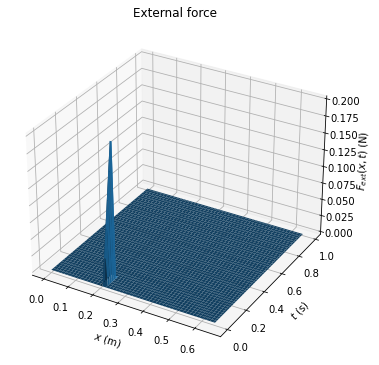

/home/xabbu/anaconda3/envs/env_pam_hr/lib/python3.9/site-packages/numpy/linalg/linalg.py:2546: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


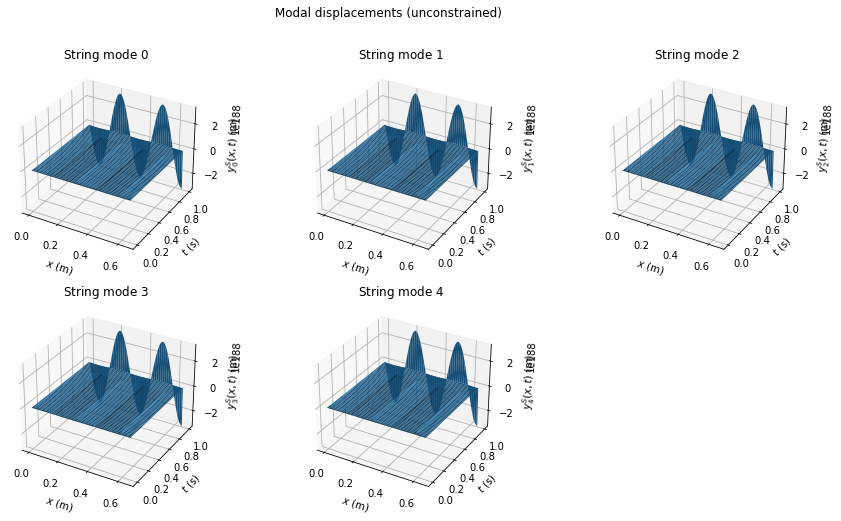

In [8]:
x = np.linspace(0, string.data.l, log.nb_points)
xx = np.outer(x, np.ones_like(t))
tt = np.outer(np.ones_like(x), t)

if log.do_save:
    df_q_n.to_csv(output_spreadsheet_path / 'q_n.csv')
    df_ddq_n.to_csv(output_spreadsheet_path / 'dq_n.csv')
    df_ddq_n.to_csv(output_spreadsheet_path / 'ddq_n.csv')
    df_ext_force_n_t.to_csv(output_spreadsheet_path / 'ext_force_n_t.csv')

if log.do_log or log.do_save:
    # EXCITATION FORCE ext_force
    # TODO
    f_x = ext_force_string(xx, tt)
    fig = plt.figure(figsize=(6, 8))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_title(f'External force')
    ax.plot_surface(xx, tt, f_x)
    ax.set_xlabel('$x$ (m)')
    ax.set_ylabel('$t$ (s)')
    ax.set_zlabel('$F_{ext}(x, t)$ (N)')
    if log.do_log:
        plt.show()
    if log.do_save:
        fig.savefig(output_figure_path / 'ext_force.svg', facecolor='none', transparent=True)
    plt.close(fig)
    # MODAL DISPLACEMENTS y_n
    fig = plt.figure(figsize=(len(y_n) * 3, 8))
    fig.suptitle("Modal displacements (unconstrained)")

    for (j, y_j) in enumerate(y_n):
        ax = fig.add_subplot(2, len(y_n)//2+1, j+1, projection='3d')
        y_x = y_j(xx)
        #
        ax.set_title(f'String mode ${j}$')
        ax.plot_surface(xx, tt, y_x)
        ax.set_xlabel('$x$ (m)')
        ax.set_ylabel('$t$ (s)')
        ax.set_zlabel(f'$y_{j}^S(x, t)$ (m)')
    if log.do_log:
        plt.show()
    if log.do_save:
        fig.savefig(output_figure_path / 'y_n.svg', facecolor='none', transparent=True)
    plt.close(fig)